# *1.Carga de datos y análisis exploratorio de los datos (EDA)*

In [18]:
#Importación de la librerías que se usarán
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [19]:
mapeo_columnas = {
    'RESPUESTA': 'respuesta', 
    'CONSUMO_CRITICADO': 'consumo_criticado', 
    'SERVICIO': 'servicio',
    'CATEGORIA': 'categoria', 
    'NIVEL_TENSION': 'nivel_tension', 
    'ESTRATO': 'estrato', 
    'LOCALIDAD': 'localidad', 
    'FUNCION_ANALISIS': 'funcion_analisis',
    'CALIFICACION': 'calificacion',
    'OBS_LECTURA': 'obs_lectura',
    'PERIODICIDAD': 'periodicidad'
}

In [20]:
# Cargar el set de datos
archivo = "BD_ordenes.xlsx"
df = pd.read_excel(archivo)

df = df.rename(columns=mapeo_columnas)
df['registro_id'] = range(1, len(df) + 1)
column_order = ['registro_id'] + list(df.columns[:-1])  # Mueve 'registro_id' al principio
df = df[column_order]
df.head()

,registro_id,respuesta,consumo_criticado,servicio,categoria,nivel_tension,estrato,localidad,funcion_analisis,calificacion,obs_lectura,periodicidad
0,1,1,0.0,701-ENERGÍA MDO REGULADO,3-INDUSTRIAL,220.0,NaN,5088-BELLO,CALCCOPR - Calcular Consumo Penalizado de Ener...,5035-BAJO ENERGIA (<-50%),30-VARIACION NIVEL DE UTILIZACIÓN,1
1,2,1,420.0,701-ENERGÍA MDO REGULADO,3-INDUSTRIAL,220.0,NaN,5088-BELLO,CALCCOPR - Calcular Consumo Penalizado de Ener...,5080-MUY ALTO (>500%),30-VARIACION NIVEL DE UTILIZACIÓN,1
2,3,1,99999.0,101-AGUA POTABLE,1-RESIDENCIAL,NaN,1.0,5088-BELLO,CALCCOLE - Calcular Consumo por Lecturas,5080-MUY ALTO (>500%),34-LECTURA MENOR,1
3,4,1,881.0,701-ENERGÍA MDO REGULADO,3-INDUSTRIAL,220.0,NaN,5088-BELLO,CALCCOLE - Calcular Consumo por Lecturas,5080-MUY ALTO (>500%),35-NO HAY JUSTIFICACION,1
4,5,1,99999.0,701-ENERGÍA MDO REGULADO,1-RESIDENCIAL,220.0,4.0,5001-MEDELLÍN,CALCCOLE - Calcular Consumo por Lecturas,5080-MUY ALTO (>500%),34-LECTURA MENOR,1


In [21]:
# Calcular la participación de cada localidad
locality_counts = df['localidad'].value_counts()
total_records = len(df)
locality_participation = locality_counts / total_records

# Crear una nueva variable PARTICIPACION_LOCALIDAD
df['participacion_localidad'] = df['localidad'].apply(lambda x: x if locality_participation[x] >= 0.01 else '9999-OTROS')

# *2.Depuración y preparación de los datos*

In [22]:
#Rellenar los nulos correspondientes a la variable "estrato" con cero.
df['estrato'] = df['estrato'].fillna(0)
df['nivel_tension'] = df['nivel_tension'].fillna(0)

In [23]:
#Cantidad de observaciones por nivel de tensión

tabla_nivel_tension = df['nivel_tension'].value_counts(dropna=False).reset_index()
tabla_nivel_tension.columns = ['nivel_tension', 'cantidad_observaciones']
total_observaciones = tabla_nivel_tension['cantidad_observaciones'].sum()
tabla_nivel_tension['porcentaje'] = (tabla_nivel_tension['cantidad_observaciones'] / total_observaciones * 100).round(2).astype(str) + ' %'
tabla_nivel_tension

,nivel_tension,cantidad_observaciones,porcentaje
0,0.0,61218,71.34 %
1,220.0,23627,27.53 %
2,13200.0,928,1.08 %
3,44000.0,38,0.04 %


In [24]:
#Eliminar columna nivel de tensión
df.drop(columns=['nivel_tension'], inplace=True)

In [25]:
# dejar las categorías residencial, comercial e industrial y las demás categorías agruparlas
categorias_relevantes = [
    '1-RESIDENCIAL',
    '2-COMERCIAL',
    '3-INDUSTRIAL'
]

# Aplicar la transformación
df['categoria'] = df['categoria'].apply(
    lambda x: x if x in categorias_relevantes else '99-OTRAS CATEGORIAS'
)

df['categoria'].value_counts()

categoria
1-RESIDENCIAL          71003
2-COMERCIAL             8886
3-INDUSTRIAL            4478
99-OTRAS CATEGORIAS     1444
Name: count, dtype: int64

## *Feature Engineering*

In [26]:
# Diccionario de mapeo de servicio a tipo de servicio
mapeo_tipo_servicio = {
    '701-ENERGÍA MDO REGULADO': 'Energia',
    '101-AGUA POTABLE': 'Agua',
    '103-ALCANTARILLADO': 'Alcantarillado',
    '501-GAS NATURAL REGULADO': 'Gas',
    '1007-ALUMBRADO PÚBLICO MEDIDO': 'Energia',
    '8000-AGUA POTABLE OCC.': 'Agua',
    '8003-AGUA POTABLE URABA': 'Agua',
    '7505-GAS NATURAL COMPRIMIDO (GNC)': 'Gas',
    '240-AGUA POTABLE MALAMBO': 'Agua',
    '249-AGUA POTABLE DE RIONEGRO ANT': 'Agua',
    '1702-MOVILIDAD ELÉCTRICA CARGA INTE': 'Energia'
}

In [27]:
# Crear nueva columna 'tipo_servicio'
df['tipo_servicio'] = df['servicio'].map(mapeo_tipo_servicio)
df.drop(columns=['servicio'], inplace=True)
df.head()

,registro_id,respuesta,consumo_criticado,categoria,estrato,localidad,funcion_analisis,calificacion,obs_lectura,periodicidad,participacion_localidad,tipo_servicio
0,1,1,0.0,3-INDUSTRIAL,0.0,5088-BELLO,CALCCOPR - Calcular Consumo Penalizado de Ener...,5035-BAJO ENERGIA (<-50%),30-VARIACION NIVEL DE UTILIZACIÓN,1,5088-BELLO,Energia
1,2,1,420.0,3-INDUSTRIAL,0.0,5088-BELLO,CALCCOPR - Calcular Consumo Penalizado de Ener...,5080-MUY ALTO (>500%),30-VARIACION NIVEL DE UTILIZACIÓN,1,5088-BELLO,Energia
2,3,1,99999.0,1-RESIDENCIAL,1.0,5088-BELLO,CALCCOLE - Calcular Consumo por Lecturas,5080-MUY ALTO (>500%),34-LECTURA MENOR,1,5088-BELLO,Agua
3,4,1,881.0,3-INDUSTRIAL,0.0,5088-BELLO,CALCCOLE - Calcular Consumo por Lecturas,5080-MUY ALTO (>500%),35-NO HAY JUSTIFICACION,1,5088-BELLO,Energia
4,5,1,99999.0,1-RESIDENCIAL,4.0,5001-MEDELLÍN,CALCCOLE - Calcular Consumo por Lecturas,5080-MUY ALTO (>500%),34-LECTURA MENOR,1,5001-MEDELLÍN,Energia


## *Proceso de label encoding*

In [28]:
df_modelo = df.copy()

In [29]:
df_modelo['codigo_observacion'] = df_modelo['obs_lectura'].str.split('-', n=1).str[0]
df_modelo['codigo_observacion'] = df_modelo['codigo_observacion'].astype(int)
df_modelo.drop(columns=['obs_lectura'], inplace=True)

df_modelo['codigo_calificacion'] = df_modelo['calificacion'].str.split('-', n=1).str[0]
df_modelo['codigo_calificacion'] = df_modelo['codigo_calificacion'].astype(int)
df_modelo.drop(columns=['calificacion'], inplace=True)

df_modelo['codigo_localidad'] = df_modelo['participacion_localidad'].str.split('-', n=1).str[0]
df_modelo['codigo_localidad'] = df_modelo['codigo_localidad'].astype(int)
df_modelo.drop(columns=['participacion_localidad'], inplace=True)
df_modelo.drop(columns=['localidad'], inplace=True)

df_modelo['codigo_categoria'] = df_modelo['categoria'].str.split('-', n=1).str[0]
df_modelo['codigo_categoria'] = df_modelo['codigo_categoria'].astype(int)
df_modelo.drop(columns=['categoria'], inplace=True)

In [30]:

# Columnas categóricas a codificar
columnas_categoricas = ['funcion_analisis','tipo_servicio']

# Inicializar codificadores
encoders = {}
for col in columnas_categoricas:
    le = LabelEncoder()
    df_modelo[col] = le.fit_transform(df_modelo[col].astype(str))
    encoders[col] = le  # Guardamos el encoder para posibles decodificaciones posteriores

# Verificar resultado
df_modelo.head()

,registro_id,respuesta,consumo_criticado,estrato,funcion_analisis,periodicidad,tipo_servicio,codigo_observacion,codigo_calificacion,codigo_localidad,codigo_categoria
0,1,1,0.0,0.0,3,1,2,30,5035,5088,3
1,2,1,420.0,0.0,3,1,2,30,5080,5088,3
2,3,1,99999.0,1.0,2,1,0,34,5080,5088,1
3,4,1,881.0,0.0,2,1,2,35,5080,5088,3
4,5,1,99999.0,4.0,2,1,2,34,5080,5001,1


In [31]:
# Paso 1: 70% entrenamiento, 30% temporal
df_train, df_temp = train_test_split(
    df_modelo,
    test_size=0.30,
    stratify=df['respuesta'],
    random_state=42
)

In [32]:
# Paso 2: del 30% temporal, 15% test y 15% validación
df_test, df_val = train_test_split(
    df_temp,
    test_size=0.50,
    stratify=df_temp['respuesta'],
    random_state=42
)

In [33]:
# Verificar proporciones si deseas
print("Distribución entrenamiento:\n", df_train['respuesta'].value_counts(normalize=True))
print("Distribución test:\n", df_test['respuesta'].value_counts(normalize=True))
print("Distribución validación:\n", df_val['respuesta'].value_counts(normalize=True))

Distribución entrenamiento:
 respuesta
1    0.659797
0    0.340203
Name: proportion, dtype: float64
Distribución test:
 respuesta
1    0.659804
0    0.340196
Name: proportion, dtype: float64
Distribución validación:
 respuesta
1    0.659804
0    0.340196
Name: proportion, dtype: float64


In [34]:
#Guardar los resultados para despues comparar
df_test[['registro_id', 'respuesta']].to_csv('df_test_respuesta.csv', index=False)
df_val[['registro_id', 'respuesta']].to_csv('df_val_respuesta.csv', index=False)

In [35]:
cat_columns = ['estrato','tipo_servicio','codigo_localidad']

# Crear el OneHotEncoder con `handle_unknown='ignore'`
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Ajustar el encoder con el conjunto de entrenamiento
encoder.fit(df_train[cat_columns])

# Transformar los datos de entrenamiento y prueba
train_oh_encoded = encoder.transform(df_train[cat_columns])
test_oh_encoded = encoder.transform(df_test[cat_columns])
val_oh_encoded = encoder.transform(df_val[cat_columns])

# Convertir las matrices en DataFrames con los nombres de columnas adecuados
train_one_hot = pd.DataFrame(train_oh_encoded, columns=encoder.get_feature_names_out(cat_columns), index=df_train.index)
test_one_hot = pd.DataFrame(test_oh_encoded, columns=encoder.get_feature_names_out(cat_columns), index=df_test.index)
val_one_hot = pd.DataFrame(val_oh_encoded, columns=encoder.get_feature_names_out(cat_columns), index=df_val.index)

# Asegurar que ambos DataFrames tengan las mismas columnas
missing_cols = set(train_one_hot.columns) - set(test_one_hot.columns)
for col in missing_cols:
    test_one_hot[col] = 0  # Agregar columnas faltantes con valor 0

missing_cols = set(test_one_hot.columns) - set(train_one_hot.columns)
for col in missing_cols:
    train_one_hot[col] = 0  # Agregar columnas faltantes con valor 0

missing_cols = set(val_one_hot.columns) - set(train_one_hot.columns)
for col in missing_cols:
    train_one_hot[col] = 0  # Agregar columnas faltantes con valor 0

# Reordenar columnas para que coincidan en ambos conjuntos
test_one_hot = test_one_hot[train_one_hot.columns]
val_one_hot = val_one_hot[train_one_hot.columns]

# Concatenar los datos originales con las columnas one-hot
train = pd.concat([df_train.drop(columns=cat_columns), train_one_hot], axis=1)
test = pd.concat([df_test.drop(columns=cat_columns), test_one_hot], axis=1)
val = pd.concat([df_val.drop(columns=cat_columns), val_one_hot], axis=1)

In [36]:
#1. Separación de variables predictoras y objetivo del set de datos de entrenamiento
predictors_train = train.drop(columns=['respuesta','registro_id'])
target_train = train["respuesta"]

In [37]:
#1. Separación de variables predictoras y objetivo del set de datos de test
predictors_test = test.drop(columns=['respuesta','registro_id'])
target_test = test["respuesta"]

In [38]:
#1. Separación de variables predictoras y objetivo del set de datos de validación
predictors_validacion = val.drop(columns=['respuesta','registro_id'])
target_validacion = val["respuesta"]

In [39]:
# 1. Inicializamos el modelo Random Forest
randomforest = RandomForestClassifier()

# 2. Entrenamos el modelo con los datos de entrenamiento
randomforest.fit(predictors_train, target_train)
# 3. Realizamos predicciones con los datos de validación
y_pred = randomforest.predict(predictors_test)
w_pred = randomforest.predict(predictors_validacion)

# 4. Calculamos la precisión (accuracy) del modelo
acc_randomforest = round(accuracy_score(y_pred, target_test) * 100, 2)
acc_randomforest_val = round(accuracy_score(w_pred, target_validacion) * 100, 2)

# 5. Calculamos el F1 Score del modelo
f1_randomforest = round(f1_score(y_pred, target_test) * 100, 2)
f1_randomforest_val = round(f1_score(w_pred, target_validacion) * 100, 2)

# 6. Mostramos las métricas de desempeño del modelo
print(f'acc_randomforest: {acc_randomforest}')
print(f'f1_randomforest: {f1_randomforest}')
print('-'*30)
print(f'acc_randomforest_val: {acc_randomforest_val}')
print(f'f1_randomforest_val: {f1_randomforest_val}')

acc_randomforest: 85.15
f1_randomforest: 88.83
------------------------------
acc_randomforest_val: 85.0
f1_randomforest_val: 88.66


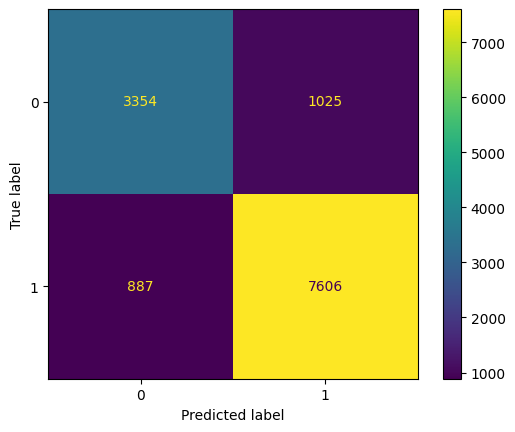

In [40]:
matriz = confusion_matrix(target_test, y_pred)
# Mostrarla visualmente
disp = ConfusionMatrixDisplay(confusion_matrix=matriz)
disp.plot();

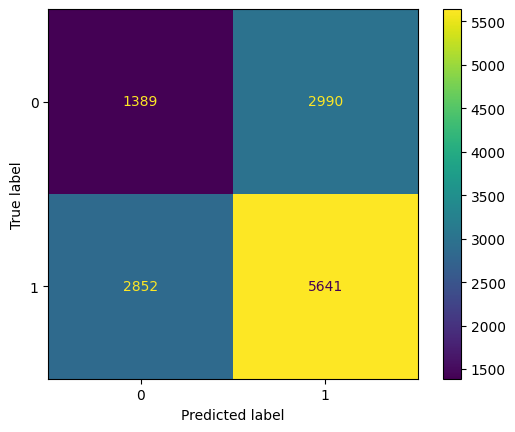

In [41]:
matriz_val = confusion_matrix(target_validacion, y_pred)
# Mostrarla visualmente
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_val)
disp.plot();

In [42]:
test.drop(columns=['respuesta'], inplace=True)

In [43]:
test.head()

,registro_id,consumo_criticado,funcion_analisis,periodicidad,codigo_observacion,codigo_calificacion,codigo_categoria,estrato_0.0,estrato_1.0,estrato_2.0,...,codigo_localidad_5001,codigo_localidad_5042,codigo_localidad_5045,codigo_localidad_5088,codigo_localidad_5266,codigo_localidad_5360,codigo_localidad_5490,codigo_localidad_5615,codigo_localidad_8433,codigo_localidad_9999
22856,22857,11.0,2,1,35,5080,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14479,14480,99955.0,2,1,39,5080,1,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
71514,71515,3.6,9,1,31,5080,1,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77510,77511,9949.0,2,1,34,5080,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15000,15001,99993.0,6,1,30,220,1,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [44]:
ids = test['registro_id']
predictions = randomforest.predict(test.drop(columns='registro_id'))
predictions = pd.DataFrame(data={'registro_id': ids, 'pred': predictions})
predictions

,registro_id,pred
22856,22857,1
14479,14480,1
71514,71515,1
77510,77511,1
15000,15001,1
...,...,...
60306,60307,1
2435,2436,1
19152,19153,1
11548,11549,0


In [45]:
#Comparacion
gender_submission = pd.read_csv('df_test_respuesta.csv')
gender_submission = gender_submission.rename(columns={'registroid': 'registro_id', 'Respuesta': 'respuesta'})
gender_submission = gender_submission.merge(predictions, on='registro_id')
gender_submission

,registro_id,respuesta,pred
0,22857,1,1
1,14480,1,1
2,71515,1,1
3,77511,1,1
4,15001,1,1
...,...,...,...
12867,60307,1,1
12868,2436,1,1
12869,19153,1,1
12870,11549,1,0


In [46]:
# Encontrar el accuracy score del modelo
acc_randomforest = round(accuracy_score(gender_submission['pred'], gender_submission['respuesta']) * 100, 2)
f1_randomforest = round(f1_score(gender_submission['pred'], gender_submission['respuesta']) * 100, 2)
print(f'acc_randomforest: {acc_randomforest}')
print(f'f1_randomforest: {f1_randomforest}')

acc_randomforest: 85.15
f1_randomforest: 88.83


In [47]:
val.drop(columns=['respuesta'], inplace=True)

In [48]:
val.head()

,registro_id,consumo_criticado,funcion_analisis,periodicidad,codigo_observacion,codigo_calificacion,codigo_categoria,estrato_0.0,estrato_1.0,estrato_2.0,...,codigo_localidad_5001,codigo_localidad_5042,codigo_localidad_5045,codigo_localidad_5088,codigo_localidad_5266,codigo_localidad_5360,codigo_localidad_5490,codigo_localidad_5615,codigo_localidad_8433,codigo_localidad_9999
26127,26128,3604.820,2,1,30,2,2,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
64481,64482,98965.000,2,1,0,5080,1,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3911,3912,1.000,2,2,30,5031,1,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85425,85426,201.578,9,3,0,2,1,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5957,5958,13.000,2,1,35,5084,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [49]:
ids_val = val['registro_id']
predictions_val = randomforest.predict(val.drop(columns='registro_id'))
predictions_val = pd.DataFrame(data={'registro_id': ids_val, 'pred': predictions_val})
predictions_val

,registro_id,pred
26127,26128,0
64481,64482,1
3911,3912,1
85425,85426,0
5957,5958,0
...,...,...
1761,1762,1
13589,13590,1
75018,75019,1
43640,43641,0


In [50]:
#Comparacion
gender_submission_val = pd.read_csv('df_val_respuesta.csv')
gender_submission_val = gender_submission_val.rename(columns={'registroid': 'registro_id', 'Respuesta': 'respuesta'})
gender_submission_val = gender_submission_val.merge(predictions_val, on='registro_id')
gender_submission_val

,registro_id,respuesta,pred
0,26128,1,0
1,64482,1,1
2,3912,1,1
3,85426,0,0
4,5958,0,0
...,...,...,...
12867,1762,1,1
12868,13590,1,1
12869,75019,1,1
12870,43641,1,0


In [51]:
# Encontrar el accuracy score del modelo
acc_randomforest_val = round(accuracy_score(gender_submission_val['pred'], gender_submission_val['respuesta']) * 100, 2)
f1_randomforest_val = round(f1_score(gender_submission_val['pred'], gender_submission_val['respuesta']) * 100, 2)
print(f'acc_randomforest: {acc_randomforest_val}')
print(f'f1_randomforest: {f1_randomforest_val}')

acc_randomforest: 85.0
f1_randomforest: 88.66
